<a href="https://colab.research.google.com/github/agcarlon/bayhess/blob/main/getting_started_bayhess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting started

*Run this example in* [colab](https://colab.research.google.com/drive/16tEQBo8GzqehT8fRoiuTA7uHF7zyIRZ4)!

In this example, we use the BayHess package to assist MICE in minimizing a quadratic function. Let the quadratic function $f$ to minimized be

$$
f(\boldsymbol{\xi}, \theta) = \frac{1}{2} \boldsymbol{\xi} \cdot \boldsymbol{H}(\theta) \boldsymbol{\xi}
- \boldsymbol{b} \cdot \boldsymbol{\xi}
$$

where

$$
\begin{aligned}
    \boldsymbol{\xi} \quad & \textrm{ is a vector containing the optimization variables, } \\
    \theta \quad & \textrm{ is a random variable, } \\
    f(\boldsymbol{\xi}, \theta) \quad & \textrm{ is a function whose expectation wrt } \theta \textrm{ is to be minimized, } \\
    \boldsymbol{H}(\theta) \quad & \textrm{ is the Hessian matrix, } \\
    \boldsymbol{b} \quad & \textrm{is a vector of the same dimension as } \boldsymbol{\xi}.
    \end{aligned}
$$

Here, we have a Hessian that is a convex combination of the identity matrix and of an arbitrary matrix:

$$
\boldsymbol{H}(\theta) =
\boldsymbol{I}_2(1 -\theta) +
\begin{bmatrix}
\kappa & \kappa-1 \\
        \kappa-1 & \kappa
\end{bmatrix}
\theta,
$$

noting that $\theta$ is a random variable such that $\theta \sim \mathcal{U}[0, 1]$
and $\kappa$ is the desired conditioning number of the expected value of the Hessian.
Also, $\boldsymbol{b}$ is a 2-dimensional vector with ones.

To use the stochastic gradient method, we need the gradient of $f$ wrt $\boldsymbol{\xi}$:

$$
\nabla_{\boldsymbol{\xi}} f(\boldsymbol{\xi}, \theta) = \boldsymbol{H}(\theta) \boldsymbol{\xi} - \boldsymbol{b}.
$$

First, let's install both MICE and BayHess from PyPI using pip.

In [ ]:
%pip install -U mice
%pip install -U bayhess

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


To use MICE to estimate $\nabla_{\boldsymbol{\xi}} f$, we need to import the MICE class and NumPy to assist us in
defining our problem. We also import the BayHess class to be used soon.

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import solve, norm
from mice import MICE, plot_mice
from bayhess import BayHess

Then, we need to define $\nabla_{\boldsymbol{\xi}} f$ as a function of $\boldsymbol{\xi}$ and an array representing a sample of $\theta$.

In [ ]:
kappa = 100
H_aux = np.array([[kappa, kappa-1], [kappa-1, kappa]])
true_hess = np.array([[kappa+1, kappa-1], [kappa-1, kappa+1]])/2
b = np.ones(2)


def dobjf(x, thetas):
    gradients = []
    for theta in thetas:
        H = np.eye(2) * (1 - theta) + H_aux * theta
        gradients.append(H @ x.T - b)
    return np.vstack(gradients)

As for $\theta$, we can pass to MICE either a sampler function that takes the desired sample size as input and returns the sample
or a list/array containing the data.
Here, we will define a function that returns the uniform sample between 0 and 1,

In [ ]:
def sampler(n):
    return np.random.uniform(0, 1, int(n))

Now, let's create an instance of MICE to solve this optimization problem with tolerance to statistical error of $\epsilon=0.7$,
maximum cost of $10,000$ evaluations of $\nabla_{\boldsymbol{\xi}} f$, and a minimum batch size of $5$.

In [ ]:
df = MICE(dobjf,
          sampler=sampler,
          eps=.7,
          min_batch=5,
          stop_crit_norm=0.1)

To perform optimization, we need to set a starting point and a step size. 
Here, we know both the $L$-smoothness and the $\mu$-convexity parameters of the problem, thus we can set the step size optimally.

In [ ]:
x = np.array([20., 50.])
L = kappa
mu = 1
step_size = 2 / (L + mu) / (1 + df.eps ** 2)

and, finally, we iterate until MICE's cost is reached, in which case df.terminate returns True,

In [ ]:
while True:
    grad = df(x)
    if df.terminate:
        break
    x = x - step_size * grad

The method get_log returns a Pandas DataFrame with the information of what happened each iteration

In [ ]:
log = df.get_log()
log

,event,num_grads,vl,bias_rel_err,grad_norm,iteration,hier_length
0,start,50,8.325038e+06,0.000000,4929.233072,1,1
1,restart,110,9.323764e+05,0.000000,1692.175712,2,1
2,dropped,240,2.285300e+06,0.112815,596.132777,3,2
3,restart,310,6.204514e+03,0.000000,154.398332,4,1
4,dropped,370,1.749817e+04,0.158454,67.030120,5,2
...,...,...,...,...,...,...,...
407,dropped,13154,2.770345e-06,0.671570,0.091703,408,13
408,dropped,13256,1.659752e-06,0.660869,0.093029,409,13
409,dropped,13356,2.985747e-04,0.680112,0.089165,410,13
410,dropped,13456,3.071257e-04,0.680305,0.087989,411,13


Now, let's plot the convergence of the norm of MICE's gradient estimates from the log DataFrame using the built-in plot_mice function.

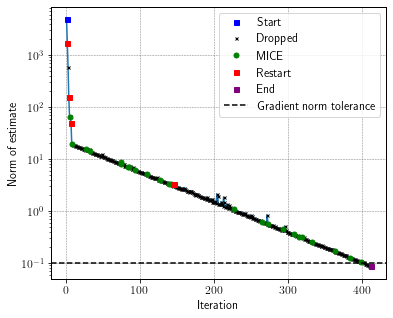

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))
ax = plot_mice(log, ax, 'iteration', 'grad_norm', style='semilogy')
ax.axhline(df.stop_crit_norm, ls='--', c='k', label='Gradient norm tolerance')
ax.set_xlabel('Iteration')
ax.set_ylabel('Norm of estimate')
ax.legend()

Note that SGD-MICE required 411 iterations to reach the gradient norm tolerance. Let's use BayHess to obtain a Hessian approximation and pre-condition the gradient with its inverse. Before, we will create another instance of MICE.

In [ ]:
df_ = MICE(dobjf,
          sampler=sampler,
          eps=.7,
          min_batch=5,
          stop_crit_norm=0.1)

And now, an instance of BayHess with $\beta=10^{-2}$ and $\rho=10^{-2}$.

In [ ]:
bay = BayHess(n_dim=2, strong_conv=1, smooth=kappa,
              penal=1e-2, reg_param=1e-2)

Setting the same startin point as for SGD-MICE and a corresponding step size of $1/(1 + \epsilon^2)$,

In [ ]:
x = np.array([20., 50.])
step_size = 1 / (1 + df.eps ** 2)

we can perform optimization using SGD-MICE-Bay.

In [ ]:
while True:
    grad = df_.evaluate(x)
    bay.update_curv_pairs_mice(df_, x)
    if not df_.k % 3:
        bay.find_hess()
    if df_.terminate:
        break
    x = x - step_size * solve(bay.hess, grad)

Similarly to what we have done before, we can check MICE's log

In [ ]:
log_ = df_.get_log()
log_

,event,num_grads,vl,bias_rel_err,grad_norm,iteration,hier_length
0,start,50,8.282787e+06,0.000000,4673.393763,1,1
1,restart,110,5.439200e+05,0.000000,1285.543559,2,1
2,restart,170,6.293673e+04,0.000000,443.603878,3,1
3,dropped,409,9.220762e+04,0.075627,142.844470,4,2
4,dropped,725,4.674741e+04,0.259342,58.760275,5,2
5,restart,795,2.109363e+02,0.000000,38.145549,6,1
6,dropped,805,1.398866e+02,0.079187,24.730780,7,2
7,dropped,825,5.015829e+01,0.100685,19.450350,8,2
8,MICE,845,3.519453e+02,0.106777,18.340809,9,2
9,dropped,875,1.184324e+02,0.209867,23.072515,10,3


And make a convergence plot.

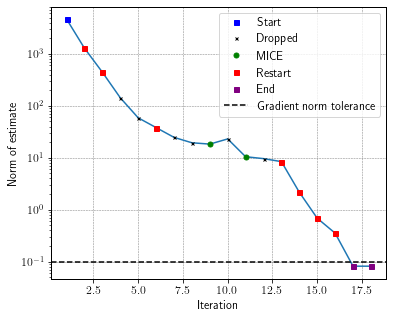

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))
ax = plot_mice(log_, ax, 'iteration', 'grad_norm', style='semilogy')
ax.axhline(df_.stop_crit_norm, ls='--', c='k', label='Gradient norm tolerance')
ax.set_xlabel('Iteration')
ax.set_ylabel('Norm of estimate')
ax.legend()

To better illustrate the difference, let's make a convergence plot comparing SGD-MICE with and without the Bayesian Hessian pre-conditioning.

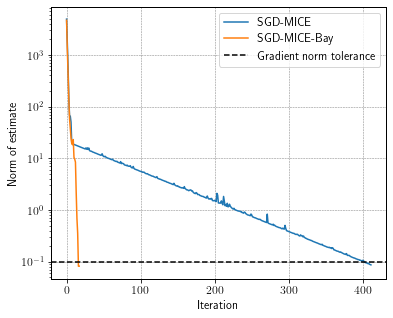

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.semilogy(log["grad_norm"], label="SGD-MICE")
ax.semilogy(log_["grad_norm"], label="SGD-MICE-Bay")
ax.axhline(df_.stop_crit_norm, ls='--', c='k', label='Gradient norm tolerance')
ax.set_xlabel('Iteration')
ax.set_ylabel('Norm of estimate')
ax.legend()

Still, due to MICE's adaptive control of the relative statistical error, the number of gradient evaluations changes per iteration. Let's take a look at the convergence versus the number of gradient evaluations.

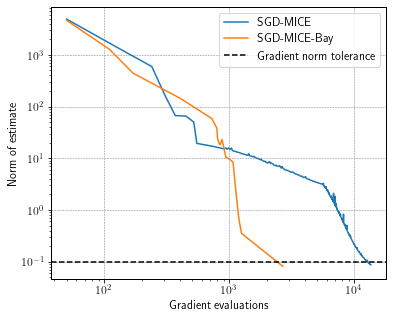

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.loglog(log["num_grads"], log["grad_norm"], label="SGD-MICE")
ax.loglog(log_["num_grads"], log_["grad_norm"], label="SGD-MICE-Bay")
ax.axhline(df_.stop_crit_norm, ls='--', c='k', label='Gradient norm tolerance')
ax.set_xlabel('Gradient evaluations')
ax.set_ylabel('Norm of estimate')
ax.legend()

Using the Hessian approximation from BayHess resulted in a dramatic reduction in the cost of achieving the desired tolerance. 


In [ ]:
reduction = (log["num_grads"].max() - log_["num_grads"].max()) / log["num_grads"].max()*100
print(f"BayHess reduced the overall cost in {reduction:.3f} %")

BayHess reduced the overall cost in 80.192 %
